# Data Generation: Sliding Window Time Series
Compatible with Qiskit 1.2.4+

### Author
- **Jacob Cybulski**, jacob.cybulski[at]deakin.edu.au<br/>
    School of IT, SEBE, Deakin University, Melbourne, Vic, Australia

### Date
- October 2022: Prepared for Workshop on Quantum Machine Learning, 13 October 2022, organised in collaboration with QWorld, QPoland, QIndia and Quantum AI Foundation. In association with IEEE Conference Trends in Quantum Computing and Emerging Business Technologies - TQCEBT 2022

### Aims
> *This script aims to create and save a data set.*

### Note
> *<font color="tomato">When running this script, you are likely to obtain slightly different results each time.</font>*

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/envs/qiskit-ml-081/lib/python311.zip',
 '/home/jacob/miniconda3/envs/qiskit-ml-081/lib/python3.11',
 '/home/jacob/miniconda3/envs/qiskit-ml-081/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/qiskit-ml-081/lib/python3.11/site-packages',
 '.']

In [2]:
import os
import numpy as np
import math
import argparse

from utils.Target import *
from utils.Window import *
from utils.TS import *
from utils.Charts import *
from utils.Files import *

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("error")

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Set the program constants

In [3]:
### interactive control
try:
    __IPYTHON__
    interactive = True
    print(f'\nInteractive execution started\n')
    get_ipython().run_line_magic('matplotlib', 'inline')
except NameError:
    interactive = False
    print(f'\nBatch execution started\n')
    
### Software version
MAJOR = 9
MINOR = 0


Interactive execution started



## Set program parameters
*Defaults are set here*

In [4]:
### Constants
LOG_NAME = 'log_test'
DATA_NAME = '2_sins_sw'
FUN_NAME = 'Target_2_sins'

### Data settings
samples_train = 70
samples_valid = 30
noise = 0.0
wind_size = 5
wind_step = 1
horizon = 1
seed = 2024

## Derive important variables

In [5]:
### Select a target class (additional parameters can be added later, see utils.py)
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # Target_beer(pt_from=104, pt_to=156)

### Function to be used
f = target_by_name(FUN_NAME)()

### Data paths within a log file
DATA_PATH = f'{LOG_NAME}/data'

### Calculated values and functions
samples = samples_train+samples_valid
train_pc = samples_train / samples

## Prepare a windowed version of data
*Values need to be in [0, 1] range*

In [6]:
### Create the continuous pure data, (X_valid, y_valid) ignored

def sw_prep_data(f, samples=100, noise=0.0, train_pc=0.7, 
                 wind_size=5, wind_step=1, horizon=1, seed=2024):
    # Create data points
    X_all, y_all, _, _, _, _ = \
        target_split(f, samples, noise=noise, train_pc=1.0, seed=seed)
    
    # Prepare X and y for training
    X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
        Xy_wind_split(y_all, wind_size, wind_step, horizon, train_pc)
    return X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts

if interactive:
    X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = sw_prep_data(f, 
        samples=samples, noise=noise, train_pc=train_pc, 
        wind_size=wind_size, wind_step=wind_step, horizon=horizon, seed=seed)
    print(f'\nCreated a data set "{f.name}": windows# train={len(y_train_ts)}, valid={len(y_valid_ts)}, '+\
          f'window size={wind_size}, step={wind_step}, horizon={horizon}, noise={noise}\n')



Created a data set "Target_2_sins": windows# train=66, valid=29, window size=5, step=1, horizon=1, noise=0.0



In [7]:
### All created files have the following codes:
#   t: training sample size
#   v: validation sample size
#   z: level of noise injected
#   w: window size
#   s: window step size
#   h: horizon size
def sw_data_id(data_name, samples_train, samples_valid, 
               noise=0.0, wind_size=5, wind_step=1, horizon=1):
    return f'{data_name}_t{samples_train}_v{samples_valid}_z{noise}_'+\
           f'w{wind_size}_s{wind_step}_h{horizon}'

if interactive:
    DATA_ID = sw_data_id(DATA_NAME, samples_train, samples_valid, noise=noise, 
                         wind_size=wind_size, wind_step=wind_step, horizon=horizon)
    print(f'\nUnique DATA_ID = "{DATA_ID}"\n')



Unique DATA_ID = "2_sins_sw_t70_v30_z0.0_w5_s1_h1"



## Test plot the data

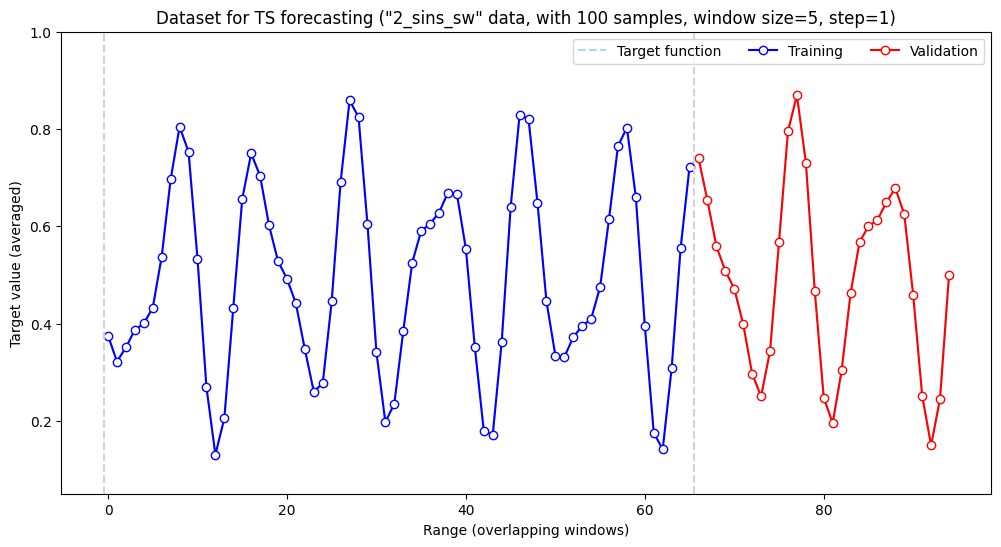

In [8]:
if interactive:

    ### Plot trainig and validation/test data partitions
    #   Note that we will not use the X coordinates
    
    y_all_select = y_all[wind_size:]
    y_train_flat_ts = ts_wind_flatten_avg(y_train_ts, wind_step)
    y_valid_flat_ts = ts_wind_flatten_avg(y_valid_ts, wind_step)
    y_list = [y_all_select, y_train_flat_ts, y_valid_flat_ts]
    X_list = [0, 0, len(y_train_flat_ts)]
    
    print()
    multi_plot_flat_ts(y_list, X_list=X_list, 
        colors = ['lightblue', 'blue', 'red'], 
        marker_colors=[None, 'white', 'white', 'lightblue', 'mistyrose'],
        labels = ['Target function', 'Training', 'Validation'], ylim=(0.05, 1),
        xlabel = 'Range (overlapping windows)', ylabel='Target value (averaged)',
        lines = ['dashed', 'solid', 'solid'], markers = [None, 'o', 'o'], legend_cols=3,
        title=f'Dataset for TS forecasting ("{DATA_NAME}" data, with {samples} samples, window size={wind_size}, step={wind_step})'
        )
    print()


## Save created dataset

In [9]:
### Save a data set
def sw_save_dataset(dpath, did,
                    X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts):
    
    ### Define file names    
    x_all_fpath = f'{dpath}/{did}/x_all.arr'
    y_all_fpath = f'{dpath}/{did}/y_all.arr'
    
    x_train_ts_fpath = f'{dpath}/{did}/x_train_ts.arr'
    y_train_ts_fpath = f'{dpath}/{did}/y_train_ts.arr'
    x_valid_ts_fpath = f'{dpath}/{did}/x_valid_ts.arr'
    y_valid_ts_fpath = f'{dpath}/{did}/y_valid_ts.arr'
    
    ### Save the history file
    write_ts_file(x_all_fpath, X_all)
    write_ts_file(y_all_fpath, y_all)
    write_ts_file(x_train_ts_fpath, X_train_ts)
    write_ts_file(y_train_ts_fpath, y_train_ts)
    write_ts_file(x_valid_ts_fpath, X_valid_ts)
    write_ts_file(y_valid_ts_fpath, y_valid_ts)

if interactive:
    sw_save_dataset(DATA_PATH, DATA_ID,
                    X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts)
    print(f'\nSaved time series data in: "{DATA_PATH}/{DATA_ID}"\n')



Saved time series data in: "log_test/data/2_sins_sw_t70_v30_z0.0_w5_s1_h1"



In [10]:
### Save info details
def sw_save_dataset_info(data_path, data_id, data_name,
    samples_train, samples_valid, noise, 
    wind_size, wind_step, horizon, seed=2024):
    global MAJOR, MINOR

    ### Define an info path
    data_info_fpath = f'{data_path}/{data_id}/info.json'

    ### Create an info record
    data_info = \
        {'data_name':data_name, 
         'major_version':MAJOR, 
         'minor_version':MINOR,
         'data_train':samples_train,
         'data_valid':samples_valid,
         'data_noise':noise,
         'wind_size':wind_size,
         'wind_step':wind_step,
         'wind_horizon':horizon,
         'seed':seed}
    
    ### Saving the info file
    write_json_file(data_info_fpath, data_info)

    return data_info, data_info_fpath

if interactive:
    data_info, info_fpath = sw_save_dataset_info(DATA_PATH, DATA_ID, DATA_NAME,
        samples_train, samples_valid, noise,
        wind_size, wind_step, horizon, seed=seed)
    print(f'\nSaved time series info in file "{info_fpath}":\n')
    for k in data_info.keys():
        print(f'\tinfo[{k}] = {data_info[k]}')
    print()



Saved time series info in file "log_test/data/2_sins_sw_t70_v30_z0.0_w5_s1_h1/info.json":

	info[data_name] = 2_sins_sw
	info[major_version] = 9
	info[minor_version] = 0
	info[data_train] = 70
	info[data_valid] = 30
	info[data_noise] = 0.0
	info[wind_size] = 5
	info[wind_step] = 1
	info[wind_horizon] = 1
	info[seed] = 2024



## System details

In [11]:
import sys
print(f'Environment:\n\n{sys.prefix}\n')

Environment:

/home/jacob/miniconda3/envs/qiskit-ml-081



In [12]:
import os
print(f"Significant packages:\n")
os.system('pip list | grep -e qiskit -e torch');

Significant packages:

qiskit                        1.2.4
qiskit-aer-gpu                0.15.1
qiskit-algorithms             0.3.1
qiskit-ibm-runtime            0.32.0
qiskit-machine-learning       0.8.1
qiskit-optimization           0.6.1
qiskit-sphinx-theme           1.16.1


## Main

In [13]:
### Fetch all program parameters
#   log: Log name
#   -d --data: Data name
#   -f --fun: Function names
#   -sn --samples: sample size
#   -st --tsamples: training samples
#   -sv --vsamples: validation samples
#   -z: level of noise injected
#   -wn -window: window size
#   -ws --step: window step
#   -wh --horizon: window horizon
#   -rs --seed: random seed

def sw_get_vars():
    global LOG_NAME, DATA_NAME, FUN_NAME, DATA_PATH
    global samples, samples_train, samples_valid, train_pc, noise
    global wind_size, wind_step, horizon
    global f, seed

    parser = argparse.ArgumentParser()
    parser.add_argument("log", type=str, help="log relative path")
    parser.add_argument("-d", "--data", type=str, help="data name", default="sin")
    parser.add_argument("-f", "--fun", type=str, help="name of generating function", default="Target_sin")
    parser.add_argument("-sn", "--samples", type=int, help="sample size", default=100)
    parser.add_argument("-st", "--tsamples", type=int, help="size of training sample", default=70)
    parser.add_argument("-sv", "--vsamples", type=int, help="size of validation sample", default=30)
    parser.add_argument("-pcs", "--split", type=float, help="percentage split", default=0.7)
    parser.add_argument("-z", "--noise", type=float, help="noise level", default=0.0)
    parser.add_argument("-wn", "--window", type=int, help="window size", default=5)
    parser.add_argument("-ws", "--step", type=int, help="window step", default=1)
    parser.add_argument("-wh", "--horizon", type=int, help="window horizon", default=1)
    parser.add_argument("-rs", "--seed", type=int, help="random seed", default=2024)

    args = parser.parse_args()
    
    return args

In [14]:
### Main function, executed in batch mode only

def main():
    global LOG_NAME, DATA_NAME, FUN_NAME, DATA_PATH
    global samples, samples_train, samples_valid, train_pc, noise
    global wind_size, wind_step, horizon
    global f, seed

    ### Execute the process
    print(f'\nSteps taken:')

    ### Create a data set
    X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = sw_prep_data(f, 
        samples=samples, noise=noise, train_pc=train_pc, 
        wind_size=wind_size, wind_step=wind_step, horizon=horizon, seed=seed)
    print(f'\n1. Created a data set "{f.name}": windows# train={len(y_train_ts)}, valid={len(y_valid_ts)}, '+\
          f'window size={wind_size}, step={wind_step}, horizon={horizon}, noise={noise}\n')

    ### Create a unique data ID
    DATA_ID = sw_data_id(DATA_NAME, samples_train, samples_valid, noise=noise, 
                         wind_size=wind_size, wind_step=wind_step, horizon=horizon)
    print(f'2. Unique DATA_ID = "{DATA_ID}"')

    ### Save a dataset
    sw_save_dataset(DATA_PATH, DATA_ID,
        X_all, y_all, X_train_ts, y_train_ts, X_valid_ts, y_valid_ts)
    print(f'\n3. Saved time series data in: "{DATA_PATH}/{DATA_ID}"')

    ### Save dataset info
    data_info, info_fpath = sw_save_dataset_info(DATA_PATH, DATA_ID, DATA_NAME,
        samples_train, samples_valid, noise,
        wind_size, wind_step, horizon, seed=seed)
    print(f'\n4. Saved time series info in file "{info_fpath}":\n')
    for k in data_info.keys():
        print(f'\tinfo[{k}] = {data_info[k]}')
    print()


In [15]:
### Execute the process
if not interactive:

    ## Get external variables
    args = sw_get_vars()

    ## Assign locals vars
    LOG_NAME = args.log
    DATA_NAME = args.data
    FUN_NAME = args.fun
    DATA_PATH = f'{LOG_NAME}/data'

    ## Get the windows parameters
    samples_train = args.tsamples
    samples_valid = args.vsamples
    noise = args.noise
    wind_size = args.window
    wind_step = args.step
    horizon = args.horizon
    seed = args.seed

    ## Calculate important vars
    samples = samples_train+samples_valid
    train_pc = samples_train / samples
    f = target_by_name(FUN_NAME)()

    main()